# Reproducción Paper


### paquetes


In [1]:
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
import astropy.units as u
from sunkit_instruments.goes_xrs import calculate_temperature_em
import matplotlib.pyplot as plt
import numpy as np
from sunpy.data import manager
import netCDF4 as nc
import os
import pandas as pd
from datetime import datetime, timedelta
import copy
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap

/home/paula/anaconda3/envs/sunpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Funciones

In [2]:
# Descargar datos

def Download_Data(start_time, end_time):
    
    #  Buscar y descargar los datos de GOES
    result = Fido.search(a.Time(start_time, end_time), a.Instrument.goes)
    archivos = Fido.fetch(result)

    #  Cargar los datos en un TimeSeries
    goes_ts = TimeSeries(archivos[0], source="XRS")
    print(goes_ts)
    goes_ts.peek()

    return goes_ts

# Truncar datos

def Truncate_Data(goes_ts, flare_start_time, flare_end_time):
    # Seleccionar el rango de interés
    goes_flare = goes_ts.truncate(flare_start_time, flare_end_time)

    # Verificar si hay datos disponibles
    if len(goes_flare.to_dataframe()) == 0:
        raise ValueError("El rango de datos seleccionado está vacío. Revisa las fechas.")

    goes_flare.peek()

    return goes_flare

#Verificar Resolución temporal (dice dentro de goes_ts: Resolution 1.0 s)

def temporal_resolution (goes_ts, res_temporal=1, tolerancia = 1e-3, top_n=5):
    # Obtener el DataFrame interno
    df = goes_ts.to_dataframe()

    # Extraer los tiempos (índice del DataFrame)
    times = df.index

    # Calcular diferencias de tiempo
    time_deltas = np.diff(times)

    # Mostrar la primera diferencia
    print("Primera diferencia:", time_deltas[0], "Segunda diferencia:", time_deltas[1])

    #convertir a segundos
    deltas_seg = time_deltas / np.timedelta64(1, 's')
    print("La primera diferencia en segundos es:", deltas_seg[0], "segundos")
    print("La segunda diferencia en segundos es:", deltas_seg[1], "segundos")

    # Comprobar si todas las diferencias son de 1 segundo o de cuánto
    # Crear el delta objetivo
    delta_objetivo = np.timedelta64(res_temporal, 's')  # segundos

    # Comparar todas las diferencias
    todos_iguales = np.all(time_deltas == delta_objetivo)

    print(f"¿Todas las diferencias son de {delta_objetivo} segundos?: {todos_iguales}")

    # Crear una máscara booleana para identificar los que NO coinciden
    mask_diferente = time_deltas != delta_objetivo

    # Mostrar las diferencias que no son iguales
    print("diferencias que no son iguales:",time_deltas[mask_diferente])

    # Establecer tolerancia (por ejemplo, ±1e-6 segundos = 1 microsegundo)
    #tolerancia = 1e-6
    #1e-3 → para milisegundos (más relajado)
    #tolerancia = 1e-3
    # Verificar si todas las diferencias están dentro de la tolerancia
    dentro_de_tolerancia = np.abs(deltas_seg - res_temporal) < tolerancia
    todos_aproximadamente_iguales = np.all(dentro_de_tolerancia)

    print(f"¿Todas las diferencias son aproximadamente {res_temporal} segundo(s) (±{tolerancia}s)?: {todos_aproximadamente_iguales}")

    # Mostrar diferencias que no cumplen
    if not todos_aproximadamente_iguales:
        print("Diferencias fuera de tolerancia:", deltas_seg[~dentro_de_tolerancia])


    # Mostrar diferencias fuera de tolerancia
    if not todos_aproximadamente_iguales:
        diferencias_fuera = deltas_seg[~dentro_de_tolerancia]
        print("Cantidad de diferencias fuera de tolerancia:", len(diferencias_fuera))
        print(f"Las {min(top_n, len(diferencias_fuera))} diferencias más grandes (por valor absoluto):")
        for val in np.sort(np.abs(diferencias_fuera - res_temporal))[-top_n:][::-1]:
            print(f"  Desviación de ±{val:.6f} s")

    return todos_aproximadamente_iguales
    

#calcular background como el valor mínimo en los 10 min anteriores a la fulguración

def go_background(goes_flare, flare_start_time, channel='xrsa', window_minutes=10):
    # convertimos el tipo de tiempo (flare_start_time) de string a datetime.strptime
    if isinstance(flare_start_time, str):
        flare_start_time = datetime.strptime(flare_start_time, "%Y-%m-%d %H:%M:%S")

    

    # tiempo final de observación para calcular el background = tiempo inicial del flare + 10 min
    window_finish =  flare_start_time + timedelta(minutes=window_minutes) #flare_start_time + 10 min
    flux = goes_flare.data[channel]
    background_level = np.min(flux[flare_start_time:window_finish])

    print(f'Valor de background banda {channel}: {background_level}')

    # --- GRAFICAR ---

    time_delta1 =  flare_start_time + timedelta(seconds=6) #flare_start_time + 6 seg
    time_delta2 =  flare_start_time - timedelta(seconds=6) #flare_start_time - 6 seg

    flare_start_index = flare_start_time

    time = goes_flare.data.index

    flare_start_index = np.argwhere((time>time_delta2) & (time<time_delta1))[0][0]
    print(f'valor de flare_start_index: {flare_start_index}')
        


    plt.figure(figsize=(10, 5))
    plt.plot(time, flux, label=f'Flujo de rayos X ({channel})', color='blue')
    plt.axhline(background_level, color='red', linestyle='--', label='Nivel de fondo estimado')
    plt.axvline(time[flare_start_index], color='green', linestyle='--', label='Inicio estimado de fulguración')
    plt.xlabel('Tiempo')
    plt.ylabel('Flujo de rayos X [W/m²]')
    plt.title(f'Estimación del nivel de fondo previo a la fulguración- canal: {channel}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return background_level

## Background calculado por GOES - solo para GOES 16, 17 y 18

### Función que carga y lee archivos .nc (se necesita porque el archivo que contiene el backgroun es .nc)
def load_netcdf(file_path):
    if not os.path.exists(file_path):
        print(f"Error: El archivo {file_path} no existe.")
        return
    
    try:
        dataset = nc.Dataset(file_path, mode='r')
        print("Contenido del archivo NetCDF:")
        print("Dimensiones:")
        for dim in dataset.dimensions:
            print(f"  {dim}: {len(dataset.dimensions[dim])}")
        
        print("\nVariables:")
        for var in dataset.variables:
            print(f"  {var}: {dataset.variables[var].dimensions} - {dataset.variables[var].shape}")
        
        print("\nPrimeros datos de cada variable:")
        for var in dataset.variables:
            try:
                data = dataset.variables[var][:5]  # Muestra los primeros 5 valores si es posible
                print(f"  {var}: {data}")
            except Exception as e:
                print(f"  No se pueden mostrar datos de {var}: {e}")

        return dataset  # Retorna el dataset para su uso en otras funciones
    except Exception as e:
        print(f"Error al cargar el archivo NetCDF: {e}")
        return None

### Función para convertir los datos en un DataFrame de pandas
def netcdf_to_dataframe(dataset):
    if dataset is None:
        print("Error: No hay un dataset cargado.")
        return None
    
    try:
        data_dict = {}
        for var in dataset.variables:
            data_dict[var] = dataset.variables[var][:]
        print("Conversión de DataFrame de pandas")
        df = pd.DataFrame(data_dict)
        return df
    except Exception as e:
        print(f"Error al convertir NetCDF a DataFrame: {e}")
        return None

### Función para calcular los segundos desde el 2000
def count_leap_seconds_since_2000(seconds_since_base):
    """
    Devuelve el número de segundos desde el 1 de enero de 2000.
    Lista actualizada de segundos intercalares: https://www.nist.gov/pml/time-and-frequency-division/time-realization/leap-seconds
    """
    leap_seconds_list = [
        (datetime(2000, 1, 1, 0, 0, 0), 0),   # Base time
        (datetime(2005, 12, 31, 23, 59, 59), 1),
        (datetime(2008, 12, 31, 23, 59, 59), 2),
        (datetime(2012, 6, 30, 23, 59, 59), 3),
        (datetime(2015, 6, 30, 23, 59, 59), 4),
        (datetime(2016, 12, 31, 23, 59, 59), 5),
    ]
    
    base_time = datetime(2000, 1, 1, 12, 0, 0)
    target_time = base_time + timedelta(seconds=seconds_since_base)
    
    leap_seconds = 0
    for date, leap in leap_seconds_list:
        if target_time > date:
            leap_seconds = leap
        else:
            break
    
    return leap_seconds

### Función para convertir segundos a fecha 
def seconds_to_datetime(seconds_since_base, include_leap_seconds=False):
    # Definir la época base: 2000-01-01 12:00:00 UTC
    base_time = datetime(2000, 1, 1, 12, 0, 0)
    
    # Calcular los segundos intercalares si se incluyen
    leap_seconds = 0
    if include_leap_seconds:
        leap_seconds = count_leap_seconds_since_2000(seconds_since_base)
    
    # Sumar los segundos transcurridos + segundos intercalares
    result_time = base_time + timedelta(seconds=seconds_since_base + leap_seconds)
    
    return result_time.strftime('%Y-%m-%d %H:%M:%S UTC')

### Función para convertir fecha a segundos
def datetime_to_seconds(date_str, include_leap_seconds=False):
    # Definir la época base: 2000-01-01 12:00:00 UTC
    base_time = datetime(2000, 1, 1, 12, 0, 0)
    
    # Convertir la fecha de entrada a un objeto datetime
    target_time = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
    
    # Calcular la diferencia en segundos
    seconds_since_base = int((target_time - base_time).total_seconds())
    
    # Restar los segundos intercalares si se incluyen
    leap_seconds = 0
    if include_leap_seconds:
        leap_seconds = count_leap_seconds_since_2000(seconds_since_base)
        seconds_since_base -= leap_seconds
    
    return seconds_since_base

### Función para obtener valores de un tiempo específico
def get_value_by_time(df, time_value, variable_name):
    if df is None:
        print("Error: No hay un DataFrame cargado.")
        return None
    
    if variable_name not in df.columns:
        print(f"Error: La variable '{variable_name}' no existe en el DataFrame.")
        return None
    
    try:
        result = df.loc[df['time'] == time_value, variable_name]
        return result.values[0] if not result.empty else None
    except Exception as e:
        print(f"Error al obtener el valor para el tiempo {time_value}: {e}")
        return None

## Background calculado por GOES - solo para GOES 16, 17 y 18
def go_GOES_background (file_path, start_time, end_time):

        '''Segundo a datatime
        según datos de background: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/docs/GOES-R_XRS_L2_Data_Users_Guide.pdf

        background
        donde encontrar los datos de backgroun de GOES 16, 17 y 18: https://www.ncei.noaa.gov/products/goes-r-extreme-ultraviolet-xray-irradiance

        datos de background: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/xrsf-l2-bkd1d_science/


        # Restar el background y aplicar factor de conversión
        # https://www.ngdc.noaa.gov/stp/satellite/goes/doc/GOES_XRS_readme.pdf -> factor de conversión (scaling_factor)'''

        # Función que carga y lee el archivo donde se encuentran los datos de background de GOES del 2017 al 2025:
        dataset = load_netcdf(file_path)
        if dataset:
            print("El archivo se cargó correctamente.")
            print("Variables disponibles:", dataset.variables.keys())
            print("Primeros valores de 'time':", dataset.variables['time'][:5])
            
        if not os.path.exists(file_path):
            print(f"Error: El archivo en '{file_path}' no existe.")
        else:
            print(f"El archivo existe en: {file_path}")
        
        #background_level=0
        print("Ahora convertimos a pandas:")
        df = netcdf_to_dataframe(dataset)
        print(df)
        
        # Calcula la diferencia entre tiempos consecutivos
        df['time_diff'] = df['time'].diff()

        time_difference = df['time'].iloc[1] - df['time'].iloc[0]
        print("Diferencia entre el segundo y el primer elemento:", time_difference, "segundos")


        # Muestra los valores únicos de la diferencia de tiempo
        print(df['time_diff'].unique())

        # También puedes obtener la resolución más común
        print("Resolución temporal más frecuente:", df['time_diff'].mode()[0], "segundos")

        #Resolución temporal en minutos
        time_difference_minutes = time_difference / 60
        print("Diferencia en minutos:", time_difference_minutes, "minutos")

        #Resolución temporal en horas
        time_difference_hours = time_difference / 3600
        print("Diferencia en horas:", time_difference_hours, "horas")

        #Resolución temporal en días
        time_difference_days = time_difference / 86400
        print("Diferencia en días:", time_difference_days, "días")

        # Funciones para calcular el tiempo en segundos para extraer el background:
        ## no tengo un valor de background para cada tiempo porque solo tengo un valor de background por día
        ## entonces se mira en el intervalo del día cual valor se asigna
        start_date = start_time
        end_date = end_time
        
        date_string = start_time
        time_in_seconds = datetime_to_seconds(date_string, include_leap_seconds=True)
        #Comprobar que el # de segundos si corresponde a la fecha estudiada
        date = seconds_to_datetime(time_in_seconds, include_leap_seconds=True)
        print("Fecha del flare:", {date_string}, "En segundos:", {time_in_seconds}, "comprobar fecha:", {date})

        
        t_inicio = datetime_to_seconds(start_date, include_leap_seconds=True)
        t_fin = datetime_to_seconds(end_date, include_leap_seconds=True)
        print('tiempo inicio:', start_date, 'corresponde a:', t_inicio, 'segundos')
        print('tiempo final:', end_date, 'corresponde a:', t_fin, 'segundos')
        
        # Filtrar el DataFrame según el intervalo del día del flare
        df_filtrado = df[(df['time'] >= t_inicio) & (df['time'] <= t_fin)]

        # Imprimir el resultado
        print(df_filtrado)

        valor_time = df_filtrado['time'].values[0]
        print("Tiempo en segundos del que extraeremos el valor de background",{valor_time})

        # Función para obtener valores de un tiempo específico
        time_value= valor_time
        variable_name = "bkd1d_xrsa_flux"  # Cambia esto por la variable que deseas consultar
        value_a = get_value_by_time(df, time_value, variable_name)
        if value_a is not None:
            print(f"Valor de {variable_name} en {time_value}: {value_a}")

        variable_name = "bkd1d_xrsb_flux"  # Cambia esto por la variable que deseas consultar
        value_b = get_value_by_time(df, time_value, variable_name)
        if value_b is not None:
            print(f"Valor de {variable_name} en {time_value}: {value_b}")

        return value_a, value_b

# Restar el background y aplicar factor de conversión
# https://www.ngdc.noaa.gov/stp/satellite/goes/doc/GOES_XRS_readme.pdf -> factor de conversión (scaling_factor)
# NO se aplica factor de conversión a GOES: 16, 17, 18 ->scaling_factor_a=1, scaling_factor_b=1
def Goes_Background(goes_flare, go_background_a, go_background_b, scaling_factor_a=0.85, scaling_factor_b=0.7):

    # go_background_a: background calculado de la banda xrsa (canal corto 0.5 - 4 Å)
    # go_background_b: background calculado de la banda xrsb (canal largo 1 - 8 Å)

    #  Extraer los datos de rayos X blandos y duros
    df = goes_flare.to_dataframe()
    print(f'Extraer los datos de rayos X blandos y duros:')
    flux_xrsa = df["xrsa"]  # Canal 0.5-4 Å (rayos X - canal corto)
    flux_xrsb = df["xrsb"]  # Canal 1-8 Å (rayos X - canal blandos)

    print(df)

    # Restar el background
    # Asegurar que no haya valores negativos (si es necesario)
    # Si el valor ya es mayor o igual a 0, se mantiene igual.

    print(f'vamos a restar el background:')

    df["xrsa_clean"] = (flux_xrsa - go_background_a)*scaling_factor_a #/1.42
    df["xrsb_clean"] = (flux_xrsb - go_background_b)*scaling_factor_b #corrección en la banda larga (1-8 A)
    print(df)

    # Copia de los datos del flare (goes_flare) para no modificar los originales
    goes_flare_corrected = copy.deepcopy(goes_flare)
    print(f'imprimir Copia de los datos del flare (goes_flare) para no modificar los originales')
    print(goes_flare_corrected)

    # Verificamos que goes_flare_corrected y df tengan los mismos índices para poder reemplazar columnas
    print(f'Verificamos que goes_flare_corrected y df tengan los mismos índices para poder reemplazar columnas')
    same_index = goes_flare_corrected.data.index.equals(df.index)
    print(f'goes_flare_corrected y df tienen los mismos índices: {same_index}')

    # imprimimos los primeros datos de df y goes_flare_corrected para ver los indices
    print(df["xrsb_clean"].head())
    print(goes_flare_corrected.data.index[:5])

    # imprimimos los datos que vamos a reemplazar de df en goes_flare_corrected
    print(f'imprimimos los datos que vamos a reemplazar de df en goes_flare_corrected')
    combined = pd.concat([goes_flare_corrected.data["xrsa"], df["xrsa_clean"], goes_flare_corrected.data["xrsb"], df["xrsb_clean"]], axis=1)
    print(combined.head())

    # reemplazamos los datos en la columa y verificamos que si copiaron
    print(f'reemplazamos los datos en la columa y verificamos que si copiaron')
    goes_flare_corrected.data["xrsa"] = df["xrsa_clean"]
    goes_flare_corrected.data["xrsb"] = df["xrsb_clean"]
    combined = pd.concat([goes_flare_corrected.data["xrsa"], df["xrsa_clean"], goes_flare_corrected.data["xrsb"], df["xrsb_clean"]], axis=1)
    print(combined.head())

    print(f'imprimir goes corregidos:')
    print(goes_flare_corrected)

    # verificamos que no se haya modificado el archivo original (goes_flare)
    #print(goes_flare)

    
    return goes_flare_corrected


# Calcular la Temperatura y Medida de emisión con los datos corregidos
def Calculate_Tem_EM(goes_flare_corrected):
    
    #  Saltar la verificación del hash temporalmente
    with manager.skip_hash_check():
        temp_em = calculate_temperature_em(goes_flare_corrected)
    
    return temp_em

# Graficar
def Graphics_T_EM(goes_flare_corrected, temp_em, time_colors, title, T_min=5, T_max=30, EM_min=1e46, EM_max=1e50, umbral_temp_max = 30):

    #Límites de gráficas T: T_min, T_max (el umbral máximo de T es T_max no se se si se necesita!!!)
    #                   EM: EM_min, EM_max    
    
    # Extraer DataFrames y alinear índices
    df_temp_em = temp_em.to_dataframe()
    df_flare = goes_flare_corrected.to_dataframe()

    # Asegurarse de que estén alineados temporalmente
    df_merged = df_temp_em.join(df_flare, how='inner')

    # Extraer los datos y convertir a unidades físicas
    temperatura = df_merged["temperature"].to_numpy() * u.K             # Convertir a Kelvin
    medida_em = df_merged["emission_measure"].to_numpy() * u.cm**(-3)   # Convertir a cm⁻³
    tiempo_datetime = df_merged.index
    inicio = tiempo_datetime[0]
    # Convertir el tiempo a segundos desde el inicio para normalizar
    tiempo_segundos = (tiempo_datetime - inicio).total_seconds()


    #  Definir un umbral máximo de temperatura
    umbral_temp_max = umbral_temp_max * u.K  # 30 MegaKelvin #### si se necesita límite????

    #  Filtrar los datos
    filtro = temperatura < umbral_temp_max

    temperatura_filtrada = temperatura[filtro]
    medida_em_filtrada = medida_em[filtro]  # Asegurar que ambos tienen la misma longitud
    tiempo_segundos_filtrado = tiempo_segundos[filtro]

    
    #  Crear la figura
    plt.figure(figsize=(5, 4))

    #  Graficar con escala logarítmica en el eje X en color negro
    #plt.plot(medida_em_filtrada, temperatura_filtrada, 'x', color="black", label="Datos GOES (Background Restado)")

  
    #Graficar con escala logarítmica en el eje X en colores
    # Graficar usando scatter y coloreando por el tiempo - TODOS LOS PUNTOS EN ESCALA DE COLOR
    '''sc = plt.scatter(medida_em_filtrada,
                        temperatura_filtrada,  #.to_value(u.MK),  # Convertimos a MK para el eje Y
                        c=tiempo_segundos_filtrado, 
                        marker='+',
                        cmap='viridis', # El argumento cmap='viridis' lo puedes cambiar a otros colormaps como 'plasma', 'inferno', 'coolwarm'
                        edgecolors='none',  # bordes en negro. edgecolor='none', entonces no hay borde que dibujar
                        linewidth=0.3, #linewidth=0.3 → bordes finitos, sutiles. 1 → bordes normales. 3 → bordes gruesos. 
                        s=20 # Tamaño de punto personalizado
                        )'''


    # Graficar con escala logarítmica en el eje X en colores
    # Graficar usando scatter y coloreando por el tiempo - PARTE DE LOS PUNTOS EN ESCALA DE COLOR - RESTO GRIS
    # Límite de tiempo para la escala de colores
    # Tiempo de referencia para colorear
    limite_dt = datetime.strptime(time_colors, "%Y-%m-%d %H:%M:%S")

    # Calcular la diferencia en segundos
    limite_tiempo = (limite_dt - inicio).total_seconds()

    
    # Máscara para separar los puntos
    mascara_coloreados = tiempo_segundos_filtrado <= limite_tiempo
    mascara_grises = tiempo_segundos_filtrado > limite_tiempo

    '''# crear colormap personalizado
    colores = ['purple', 'indigo', 'blue', 'cyan', 'green', 'yellow', 'orange', 'red']
    # Obtener el colormap 'viridis' con 256 colores
    cmap_custom = LinearSegmentedColormap.from_list("mi_cmap", colores)

    viridis = cm.get_cmap('viridis', 256)
    # Convertir a una lista de colores
    #viridis_colors = viridis(np.linspace(0, 1, 256))

    # Agregar un nuevo color al final (por ejemplo, rojo)
    #nuevo_color = np.array([[1.0, 0.0, 0.0, 1.0]])  # RGBA para rojo
    #colores_modificados = np.vstack((viridis_colors, nuevo_color))
    # Crear un nuevo colormap con el color adicional
    #cmap_custom = ListedColormap(colores_modificados)'''
    

    # Puntos con color
    sc = plt.scatter(medida_em_filtrada[mascara_coloreados],
                temperatura_filtrada[mascara_coloreados],  #.to_value(u.MK),  # Convertimos a MK para el eje Y -> ya estan en las unidades
                c=tiempo_segundos_filtrado[mascara_coloreados], 
                marker='+',
                cmap='viridis', #cmap_custom, # El argumento cmap='viridis' lo puedes cambiar a otros colormaps como 'plasma', 'inferno', 'coolwarm'
                edgecolors='none',  # bordes en negro. edgecolor='none', entonces no hay borde que dibujar
                linewidth=2, #linewidth=0.3 → bordes finitos, sutiles. 1 → bordes normales. 3 → bordes gruesos. 
                s=30 # Tamaño de punto personalizado)
                )
    # Puntos en gris
    plt.scatter(medida_em_filtrada[mascara_grises],
                temperatura_filtrada[mascara_grises],
                color='gray',
                s=5,
                marker='.',
                edgecolor='none')


    #  Ajustes del gráfico
    plt.xscale("log")  # Escala logarítmica en EM

    #  Definir los límites en los ejes
    #plt.xlim(1e46, 1e50) 
    #plt.ylim(5, 25)           
    plt.xlim(EM_min, EM_max)  # Eje X entre 10^46 y 10^50 por defecto
    plt.ylim(T_min, T_max)    # Eje Y entre 5 MK y 30 MK por defecto

    #  Etiquetas y título
    plt.xlabel("EM (cm⁻³)")
    plt.ylabel("Temperature (MK)")
    plt.title(title)

    # Barra de colores con etiqueta
    cbar = plt.colorbar(sc)
    cbar.set_label("Time since start (seconds)")
    plt.grid(True, which="both", linestyle="--", alpha=0.5)

    plt.tight_layout()

    #  Mostrar la gráfica
    plt.show()
    
    return None

######################
######   FAI   #######
######################

def plot_goes_with_fai(goes_ts, temp_em_ts,
                       delta_t=5,        # tiempo en minutos (intervalo de t para calcular la variación de parámetros)
                       em_thresh=0.005,  # en EM49 (Umbral de aumento en la EM considerado significativo)
                       Tmin=7, Tmax=14,  # en MK (Rango de Temperatura)
                       fai_dur=3,       # en minutos (Tiempo que FAI permanece elevado antes del flare)
                       Flux_min=1e-9, Flux_max=1e-4 ):
    
    # 1) DataFrame completo de EM
    df_em = temp_em_ts.to_dataframe()

    # 2) Normalizar a EM49 y calcular diff en Δt minutos
    em = df_em["emission_measure"] / 1e49
    # usaremos shift con freq para no depender del número de filas
    df_em["em_diff"] = em - em.shift(freq=pd.Timedelta(f"{delta_t}min"))

    # 3) Filtrado por temperatura Y filas con diff válidas
    mask_T = df_em["temperature"].between(Tmin*1e6, Tmax*1e6)
    mask_diff = df_em["em_diff"].notna()
    df_em_filt = df_em[mask_T & mask_diff]

    # Diagnóstico opcional
    print("EM diff • stats reales:\n", df_em_filt["em_diff"].describe())

    # 4) Detección de eventos
    fai_times = df_em_filt[df_em_filt["em_diff"] > em_thresh].index

    # 5) Agrupar cercanos
    fai_event_times = []
    for t in fai_times:
        if not fai_event_times or (t - fai_event_times[-1]) > pd.Timedelta(f"{fai_dur}min"):
            fai_event_times.append(t)
    print("FAI events:", fai_event_times)

    df_goes = goes_ts.to_dataframe()
    # 6) Extraer flujo X-ray GOES (0.5–4 Å)
    fluxa = df_goes["xrsa"]
    # 6) Extraer flujo X-ray GOES (1–8 Å)
    fluxb = df_goes["xrsb"]

    # 7) Plot
    fig, ax = plt.subplots(figsize=(10,4))
    ax.semilogy(fluxa.index, fluxa, label="GOES 0.5–4 Å")
    ax.semilogy(fluxb.index, fluxb, label="GOES 1–8 Å")
    for t in fai_event_times:
        ax.axvline(t, color='red', alpha=0.7, zorder=5)

    ax.set_xlabel("Time")
    ax.set_ylabel("X-ray Flux (W/m²)")
    ax.set_ylim(1e-9, 1e-4)
    ax.set_title("GOES X-ray Flux & FAI")
    ax.legend()
    ax.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    return fai_event_times

## SOL2022-04-20

### Datos del flare

In [3]:
#  Definir el día de la fulguración

start_time = "2024-02-25 00:00:00"
end_time = "2024-02-25 23:59:00"

In [4]:
# Definir tiempo de flare
flare_start_time = "2024-02-25 14:30:00"
flare_end_time = "2024-02-25 20:30:00"
time_colors = "2024-02-25 19:00:00" # tiempo hasta el que se grafica en escala de color

title = "SOL2024-02-25" 

### Descarga los datos del día

Files Downloaded: 100%|██████████| 4/4 [00:00<00:00,  8.26file/s]


SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality<br>xrsa_primary_chan<br>xrsb_primary_chan
Start Date:			2024-02-25 00:00:00
End Date:			2024-02-25 23:59:59
Center Date:			2024-02-25 11:59:59
Resolution:			1.0 s
Samples per Channel:		86400
Data Range(s):		xrsa                4.32E-06<br>xrsb                1.98E-05<br>xrsa_quality        2.56E+02<br>xrsb_quality        2.56E+02<br>xrsa_primary_chan   2.54E+02<br>xrsb_primary_chan   2.54E+02
Units:			W / m2<br>dimensionless
                                    xrsa      xrsb  xrsa_quality  \
2024-02-25 00:00:00.131690  4.795518e-08  0.000002             0   
2024-02-25 00:00:01.131695  5.660037e-08  0.000002             0   
2024-02-25 00:00:02.131692  5.228572e-08  0.000002             0   
2024-02-25 00:00:03.131708  4.797107e-08  0.000002             0   
2024-02-25 00:

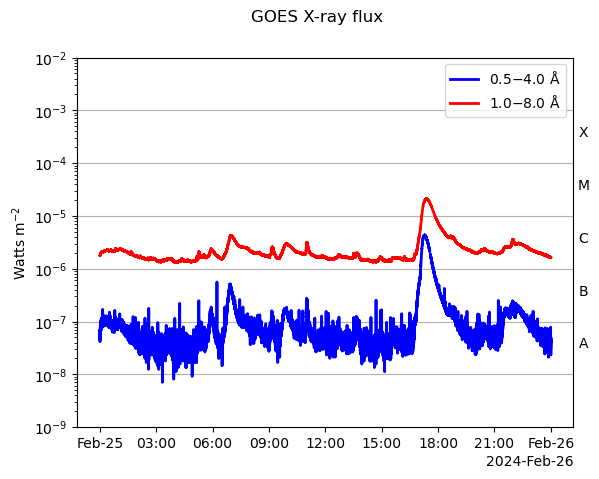

In [5]:
# Descargar los datos de un día
goes_ts = Download_Data(start_time, end_time)


### Trunca los datos del flare

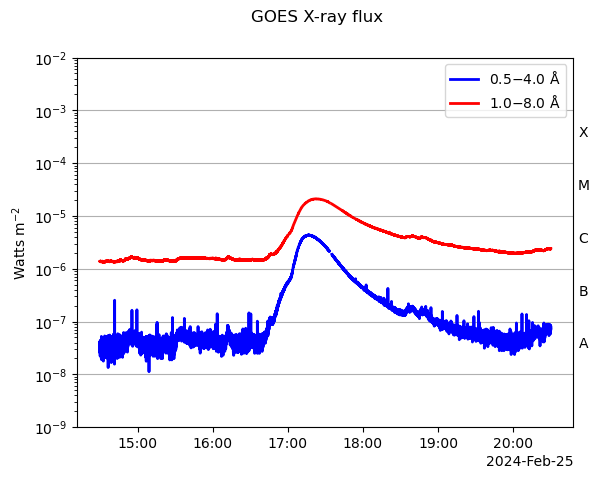

In [6]:
# Truncar datos al tiempo del flare
goes_flare = Truncate_Data(goes_ts, flare_start_time, flare_end_time)

### Verificar resolución temporal


In [7]:
temporal_resolution(goes_ts, res_temporal=1, tolerancia=1e-3, top_n=5)

Primera diferencia: 1000005000 nanoseconds Segunda diferencia: 999997000 nanoseconds
La primera diferencia en segundos es: 1.000005 segundos
La segunda diferencia en segundos es: 0.999997 segundos
¿Todas las diferencias son de 1 seconds segundos?: False
diferencias que no son iguales: [1000005000  999997000 1000016000 ... 1000002000 1000001000 1000008000]
¿Todas las diferencias son aproximadamente 1 segundo(s) (±0.001s)?: False
Diferencias fuera de tolerancia: [0.191201 1.809143]
Cantidad de diferencias fuera de tolerancia: 2
Las 2 diferencias más grandes (por valor absoluto):
  Desviación de ±0.809143 s
  Desviación de ±0.808799 s


False

### Vamos a calcular el background

#### Background calculando el mínimo 10 minutos antes de que ocurra la fulguración

In [8]:
#prueba
#go_background = 4e-07

In [9]:
# Background calculando el mínimo 10 minutos antes de que ocurra la fulguración

#go_background_a = go_background(goes_flare, flare_start_time, channel='xrsa', window_minutes=10)
#go_background_b = go_background(goes_flare, flare_start_time, channel='xrsb', window_minutes=10)

#### Background calculado por GOES - solo para GOES 16, 17 y 18

segundo a datatime
según datos de background: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/docs/GOES-R_XRS_L2_Data_Users_Guide.pdf

background
donde encontrar los datos de backgroun de GOES 16, 17 y 18: https://www.ncei.noaa.gov/products/goes-r-extreme-ultraviolet-xray-irradiance

datos de background: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/xrsf-l2-bkd1d_science/

In [10]:
# Ruta del archivo .nc en el PC donde están los datos de background de GOES (modifícar según corresponda)
#"sci_xrsf-l2-bkd1d_g16_s20170207_e20250314_v2-2-0.nc"
file_path = "/home/paula/Documentos/UN-Astronomy/Tesis/25-03_FAI/Bibliografía/sci_xrsf-l2-bkd1d_g16_s20170207_e20250314_v2-2-0.nc"
#Extracción del valor de background
go_background_a, go_background_b = go_GOES_background (file_path, start_time, end_time)

Contenido del archivo NetCDF:
Dimensiones:
  time: 2958

Variables:
  bkd1d_xrsa_flux: ('time',) - (2958,)
  bkd1d_xrsb_flux: ('time',) - (2958,)
  bkd1d_xrsa_flag: ('time',) - (2958,)
  bkd1d_xrsb_flag: ('time',) - (2958,)
  time: ('time',) - (2958,)
  avg1d_xrsa_flux: ('time',) - (2958,)
  avg1d_xrsb_flux: ('time',) - (2958,)
  avg1d_xrsa_flag: ('time',) - (2958,)
  avg1d_xrsb_flag: ('time',) - (2958,)
  avg1d_xrsa_coverage: ('time',) - (2958,)
  avg1d_xrsb_coverage: ('time',) - (2958,)

Primeros datos de cada variable:
  bkd1d_xrsa_flux: [9.9999997e-10 9.9999997e-10 1.4346336e-09 1.0083738e-09 1.0066282e-09]
  bkd1d_xrsb_flux: [3.1270432e-08 2.2764999e-08 5.1835080e-08 3.0297024e-08 3.5479687e-08]
  bkd1d_xrsa_flag: [0 0 0 0 0]
  bkd1d_xrsb_flag: [0 0 0 0 0]
  time: [5.396976e+08 5.397840e+08 5.398704e+08 5.399568e+08 5.400432e+08]
  avg1d_xrsa_flux: [7.8882305e-09 7.3544348e-09 1.5705494e-08 5.7307172e-09 3.6434877e-09]
  avg1d_xrsb_flux: [4.8892282e-08 3.4541127e-08 1.6955074e-07 

In [11]:
#go_background_a, go_background_b = go_GOES_background (file_path, start_time, end_time)
print(go_background_a)
print(go_background_b)

3.5062865e-08
1.4326288e-06


### Resta de Background

In [12]:
# Restar el background y aplicar factor de conversión
# https://www.ngdc.noaa.gov/stp/satellite/goes/doc/GOES_XRS_readme.pdf -> factor de conversión (scaling_factor)
# NO se aplica factor de conversión a GOES: 16, 17, 18 ->scaling_factor_a=1, scaling_factor_b=1
goes_flare_corrected = Goes_Background(goes_flare, go_background_a, go_background_b, scaling_factor_a=1, scaling_factor_b=1)

Extraer los datos de rayos X blandos y duros:
                                    xrsa      xrsb  xrsa_quality  \
2024-02-25 14:30:00.277785  4.042044e-08  0.000001             0   
2024-02-25 14:30:01.277790  2.961793e-08  0.000001             0   
2024-02-25 14:30:02.277792  4.042044e-08  0.000001             0   
2024-02-25 14:30:03.277802  2.531917e-08  0.000001             0   
2024-02-25 14:30:04.277796  3.608990e-08  0.000001             0   
...                                  ...       ...           ...   
2024-02-25 20:29:55.338783  7.983595e-08  0.000002             0   
2024-02-25 20:29:56.338790  7.983595e-08  0.000002             0   
2024-02-25 20:29:57.338786  7.766265e-08  0.000002             0   
2024-02-25 20:29:58.338793  7.444275e-08  0.000002             0   
2024-02-25 20:29:59.338795  7.228546e-08  0.000002             0   

                            xrsb_quality  xrsa_primary_chan  xrsb_primary_chan  
2024-02-25 14:30:00.277785             0                

2025-05-01 08:09:33 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.
2025-05-01 08:09:33 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.


                                    xrsa      xrsb  xrsa_quality  \
2024-02-25 14:30:00.277785  4.042044e-08  0.000001             0   
2024-02-25 14:30:01.277790  2.961793e-08  0.000001             0   
2024-02-25 14:30:02.277792  4.042044e-08  0.000001             0   
2024-02-25 14:30:03.277802  2.531917e-08  0.000001             0   
2024-02-25 14:30:04.277796  3.608990e-08  0.000001             0   
...                                  ...       ...           ...   
2024-02-25 20:29:55.338783  7.983595e-08  0.000002             0   
2024-02-25 20:29:56.338790  7.983595e-08  0.000002             0   
2024-02-25 20:29:57.338786  7.766265e-08  0.000002             0   
2024-02-25 20:29:58.338793  7.444275e-08  0.000002             0   
2024-02-25 20:29:59.338795  7.228546e-08  0.000002             0   

                            xrsb_quality  xrsa_primary_chan  \
2024-02-25 14:30:00.277785             0                  1   
2024-02-25 14:30:01.277790             0                 

### Cálculo T y EM

In [13]:
#Calcular temperatura y medida de emisión con los datos corregidos
temp_em = Calculate_Tem_EM (goes_flare_corrected)


2025-05-01 08:09:33 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa_clean
2025-05-01 08:09:33 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb_clean


Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.01s/file]


### Gráficas

/tmp/ipykernel_4177/3176600069.py:514: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = plt.scatter(medida_em_filtrada[mascara_coloreados],


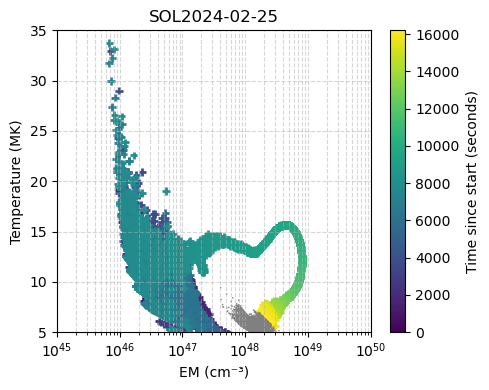

In [14]:
#gráficas
Graphics_T_EM(goes_flare_corrected, temp_em, time_colors, title, T_min=5, T_max=35, EM_min=1e45, EM_max=1e50, umbral_temp_max = 35)

## FAI

EM diff • stats reales:
 count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: em_diff, dtype: float64
FAI events: []


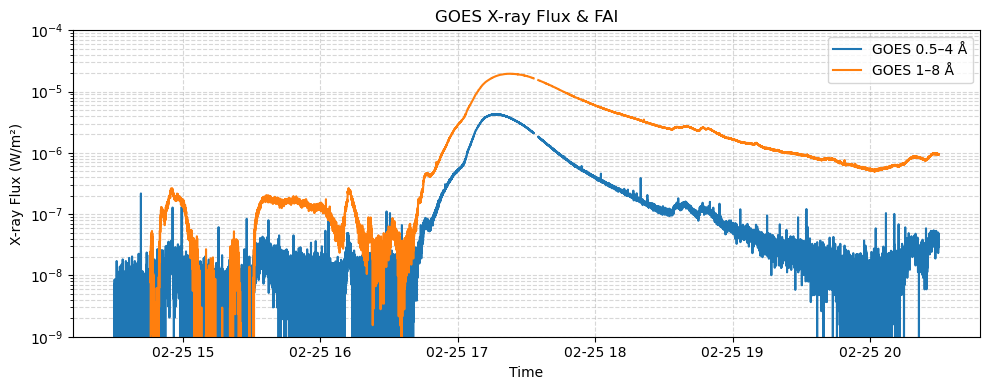

[]

In [15]:
plot_goes_with_fai(goes_flare_corrected, temp_em,
                       delta_t=5,        # tiempo en minutos (intervalo de t para calcular la variación de parámetros)
                       em_thresh=0.005,  # en EM49 (Umbral de aumento en la EM considerado significativo)
                       Tmin=7, Tmax=14,  # en MK (Rango de Temperatura)
                       fai_dur=3)       # en minutos (Tiempo que FAI permanece elevado antes del flare)


EM diff • stats reales:
 count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: em_diff, dtype: float64
FAI events: []


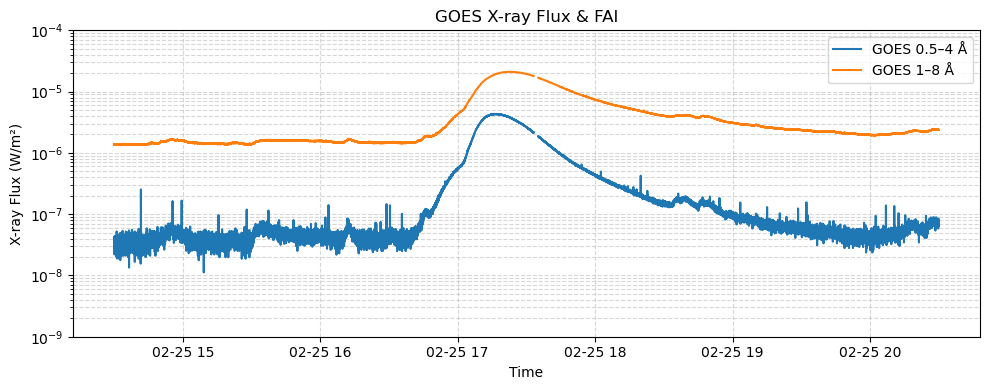

[]

In [16]:

plot_goes_with_fai(goes_flare, temp_em,
                       delta_t=5,        # tiempo en minutos (intervalo de t para calcular la variación de parámetros)
                       em_thresh=0.05,  # en EM49 (Umbral de aumento en la EM considerado significativo)
                       Tmin=7, Tmax=15,  # en MK (Rango de Temperatura)
                       fai_dur=3)       # en minutos (Tiempo que FAI permanece elevado antes del flare)
